In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
!pip install kaggle

In [4]:
# Don't forget to add kaggle.json to the directories
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 322M/330M [00:05<00:00, 28.3MB/s]
100% 330M/330M [00:05<00:00, 62.7MB/s]


In [8]:
data = "/content/face-mask-12k-images-dataset.zip"

with ZipFile(data, 'r') as zip:
  zip.extractall()
  print('Succesfully Extract the Data')


Succesfully Extract the Data


In [15]:
train_with_mask = os.listdir('/content/Face Mask Dataset/Train/WithMask')
train_without_mask = os.listdir('/content/Face Mask Dataset/Train/WithoutMask')
print(train_with_mask[:5])
print(train_without_mask[-5:])
print(f'total training images : {len(train_with_mask)+len(train_without_mask)}')

['Augmented_851_4702727.png', 'Augmented_849_52759.png', '1729.png', 'Augmented_76_156642.png', '1625.png']
['5621.png', '3743.png', '2959.png', '1368.png', '842.png']
total training images : 10000


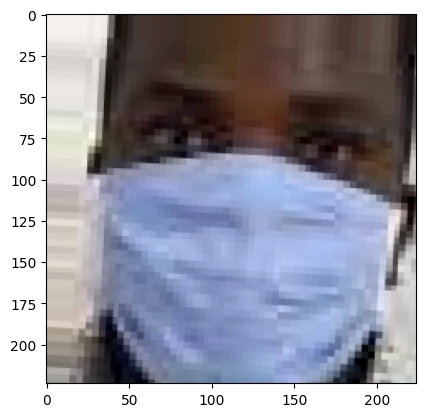

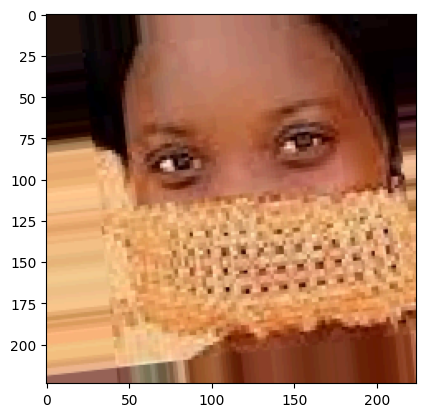

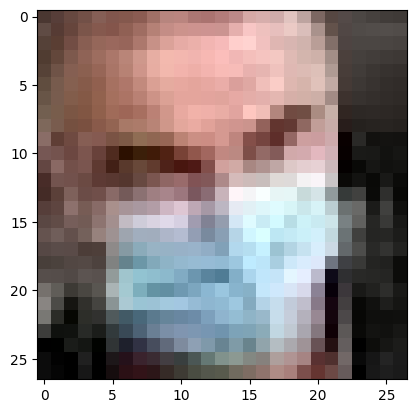

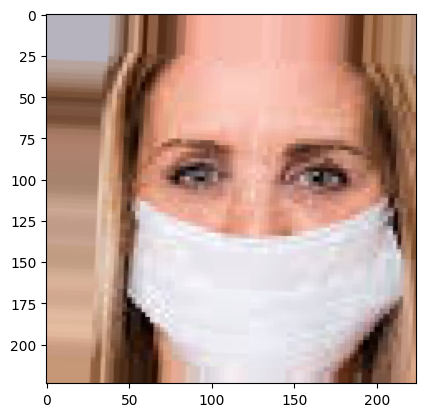

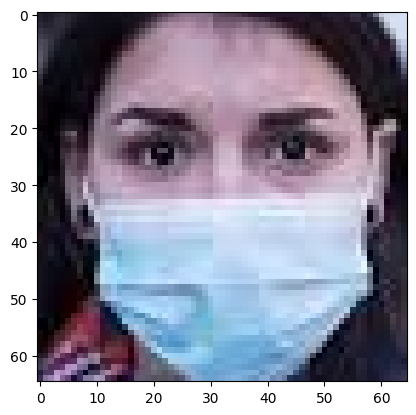

In [21]:
train_mask_path = '/content/Face Mask Dataset/Train/WithMask/'

for image in train_with_mask[:5]:
  img = mpimg.imread(train_mask_path + image)
  imgplot = plt.imshow(img)
  plt.show()

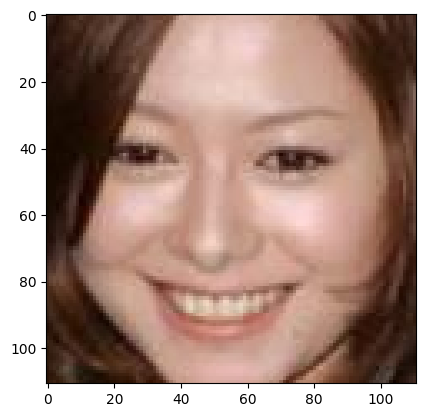

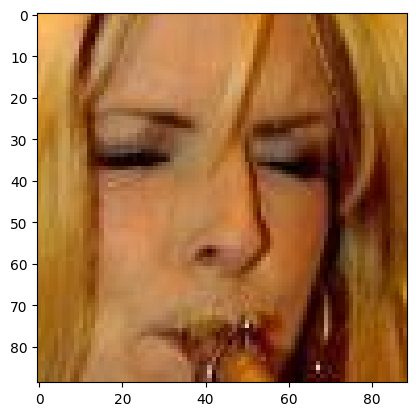

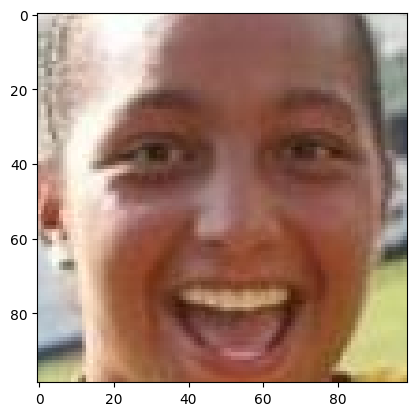

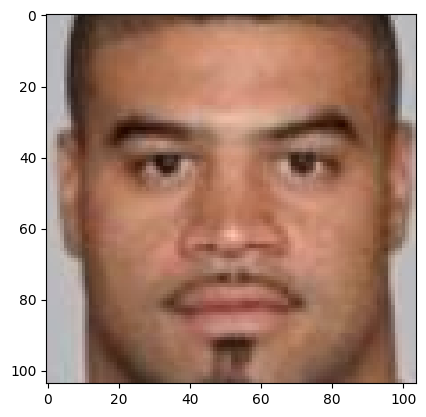

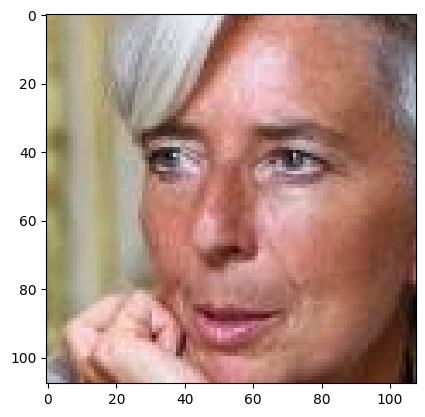

In [23]:
train_nomask_path = '/content/Face Mask Dataset/Train/WithoutMask/'

for image in train_without_mask[:5]:
  img = mpimg.imread(train_nomask_path + image)
  imgplot = plt.imshow(img)
  plt.show()

In [26]:
TRAINING_DIR = "/content/Face Mask Dataset/Train"
VALIDATION_DIR = "/content/Face Mask Dataset/Validation"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=64,
                                                    target_size=(150,150),
                                                    class_mode='binary'
                                                    )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=64,
                                                              target_size=(150,150),
                                                              class_mode='binary'
                                                              )

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

model = Sequential([])

# convolution first layer
model.add(tf.keras.layers.Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
# convolution second layer
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
# convolution third layer
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))

# Flatten layer (to flatten the input matrix to one dimensional vector)
model.add(tf.keras.layers.Flatten())
# Fully Connected Dense layer
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
# output layer using sigmoid activation because binary classification (mask or without mask)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [29]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9:
      print('\nDesired Accuracy & Validation Accuracy Achieved !')
      self.model.stop_training = True

callback = myCallBack()

In [28]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=20,
                    verbose=2,
                    callbacks=[callback]
                    )

Epoch 1/20
157/157 - 345s - loss: 0.3218 - accuracy: 0.8659 - val_loss: 0.1782 - val_accuracy: 0.9362 - 345s/epoch - 2s/step
Epoch 2/20

Desired Accuracy & Validation Accuracy Achieved !
157/157 - 347s - loss: 0.1987 - accuracy: 0.9245 - val_loss: 0.1487 - val_accuracy: 0.9463 - 347s/epoch - 2s/step


In [31]:
TEST_DIR = "/content/Face Mask Dataset/Test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=64,
    target_size=(150, 150),
    class_mode='binary',
    shuffle=False  # Set shuffle to False for the test set to keep the order of predictions
)

Found 992 images belonging to 2 classes.


In [34]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
print(f'Test Loss : {test_loss}')

16/16 [==============================] - 10s 590ms/step - loss: 0.1730 - accuracy: 0.9405
Test Accuracy: 0.9405242204666138
Test Loss : 0.17303672432899475


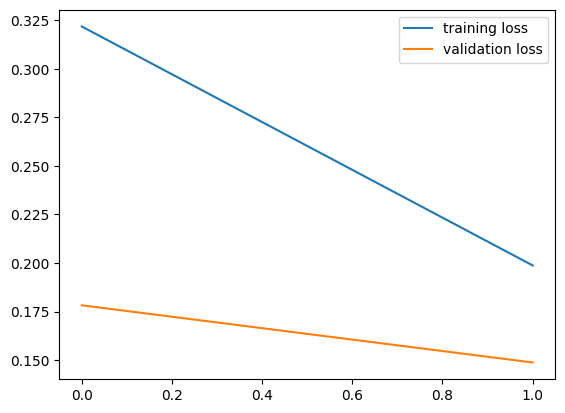

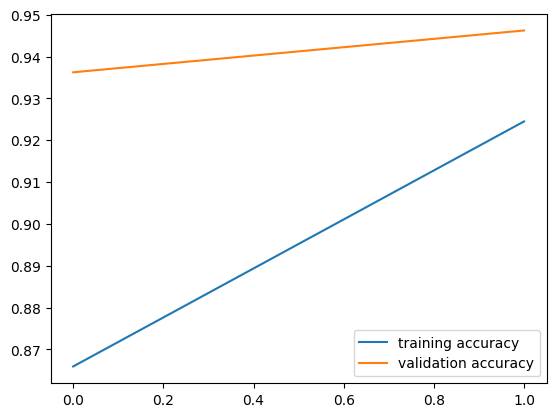

In [35]:
h = history
plt.plot(h.history['loss'], label='training loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], label='training accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [88]:
# Predict on the test set
test_predictions = model.predict(test_generator)

# Post-process the predictions
test_predictions = np.squeeze(test_predictions)  # Remove unnecessary dimensions

# Print individual predictions and corresponding filenames
for i in range(len(test_generator.filenames)):
    filename = test_generator.filenames[i]
    probability = test_predictions[i]
    probability = 1.0 - probability # KARENA KEBALIK, CLOSE TO 1 DIANGGEP GA PAKE MASKER, CLOSE TO 0 DIANGGEP PAKE MASKER :(

    if probability >= 0.5:
        prediction = 'Mask Detected'
    else:
        prediction = 'Mask Not Detected'
    print(f"{filename}: {probability:.4f} - {prediction}")

16/16 [==============================] - 9s 584ms/step
WithMask/1163.png: 0.1922 - Mask Not Detected
WithMask/1174.png: 0.7020 - Mask Detected
WithMask/1175.png: 0.8980 - Mask Detected
WithMask/1203.png: 0.1301 - Mask Not Detected
WithMask/1361.png: 0.9999 - Mask Detected
WithMask/1362.png: 0.9999 - Mask Detected
WithMask/1363.png: 0.9999 - Mask Detected
WithMask/1388.png: 1.0000 - Mask Detected
WithMask/1389.png: 0.9999 - Mask Detected
WithMask/1404.png: 0.9935 - Mask Detected
WithMask/1405.png: 1.0000 - Mask Detected
WithMask/1407.png: 0.9989 - Mask Detected
WithMask/1413.png: 0.9961 - Mask Detected
WithMask/1439.png: 0.9893 - Mask Detected
WithMask/147.png: 0.9999 - Mask Detected
WithMask/152.png: 0.9988 - Mask Detected
WithMask/153.png: 0.9988 - Mask Detected
WithMask/1558.png: 0.9610 - Mask Detected
WithMask/1559.png: 0.9851 - Mask Detected
WithMask/1565.png: 1.0000 - Mask Detected
WithMask/1573.png: 0.9985 - Mask Detected
WithMask/1606.png: 0.9999 - Mask Detected
WithMask/1607.pn

Saving Foto diri_Muhammad Raja Reivan Rivaldi.jpg to Foto diri_Muhammad Raja Reivan Rivaldi.jpg
1/1 [==============================] - 0s 35ms/step
Foto diri_Muhammad Raja Reivan Rivaldi.jpg
[[0.99727494]]
Mask Detected


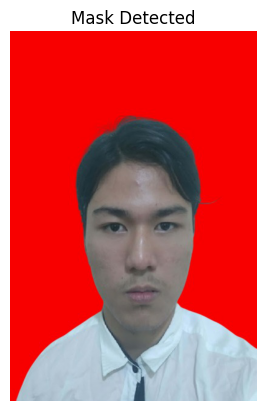

In [90]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Create an instance of ImageDataGenerator for preprocessing
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    x = datagen.standardize(x)

    return x

def display_input(probability):
  # Display the image with the prediction result
  img = load_img(path)
  plt.imshow(img)
  if probability >= 0.5:
    plt.title('Mask Detected')
  else:
    plt.title('Mask Not Detected')
  plt.axis('off')
  plt.show()

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  preprocessed_image = preprocess_image(path)
  probability = model.predict(preprocessed_image)
  print(fn)



probability = 1.0 - probability # KARENA KEBALIK, CLOSE TO 1 DIANGGEP GA PAKE MASKER, CLOSE TO 0 DIANGGEP PAKE MASKER :(
print(probability)

if probability > 0.5:
  print('Mask Detected')
else:
  print('Mask Not Detected')

display_input(probability)